In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/freckle-detection-dataset/via_export_coco.json
/kaggle/input/freckle-detection-dataset/25 may 2023 - 3 34_csv.csv
/kaggle/input/freckle-detection-dataset/dataset/dataset/val/IMG_7290.jpg
/kaggle/input/freckle-detection-dataset/dataset/dataset/val/IMG_7284.jpg
/kaggle/input/freckle-detection-dataset/dataset/dataset/val/IMG_7305.jpg
/kaggle/input/freckle-detection-dataset/dataset/dataset/val/IMG_7292.jpg
/kaggle/input/freckle-detection-dataset/dataset/dataset/val/IMG_7283.jpg
/kaggle/input/freckle-detection-dataset/dataset/dataset/val/IMG_7279.jpg
/kaggle/input/freckle-detection-dataset/dataset/dataset/val/IMG_7272.jpg
/kaggle/input/freckle-detection-dataset/dataset/dataset/val/IMG_7293.jpg
/kaggle/input/freckle-detection-dataset/dataset/dataset/val/IMG_7280.jpg
/kaggle/input/freckle-detection-dataset/dataset/dataset/val/IMG_7295.jpg
/kaggle/input/freckle-detection-dataset/dataset/dataset/val/IMG_7282.jpg
/kaggle/input/freckle-detection-dataset/dataset/dataset/val/IMG_7297.

In [10]:
import os
import json
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F

# Paths
CSV_PATH = "/kaggle/input/freckle-detection-dataset/25 may 2023 - 3 34_csv.csv"
IMAGE_DIR = "/kaggle/input/freckle-detection-dataset/dataset/dataset/train"
MODEL_SAVE_PATH = "/kaggle/working/frackel_detector.pt"

# Load and clean dataset
df = pd.read_csv(CSV_PATH)

def clean_json_field(field):
    try:
        return json.loads(field.replace("'", '"'))
    except json.JSONDecodeError:
        return {}

df['region_attributes'] = df['region_attributes'].apply(clean_json_field)
df['region_shape_attributes'] = df['region_shape_attributes'].apply(clean_json_field)

# Extract annotations
def extract_annotations(df):
    annotations = []
    for _, row in df.iterrows():
        attributes = row['region_attributes']
        shape = row['region_shape_attributes']
        
        if attributes.get('Frackels') == "1":
            cx, cy, r = shape.get('cx'), shape.get('cy'), shape.get('r')
            if cx and cy and r:
                x_min, y_min = cx - r, cy - r
                x_max, y_max = cx + r, cy + r
                annotations.append({
                    "filename": row['filename'],
                    "bbox": [x_min, y_min, x_max, y_max],
                    "label": "Frackels"
                })
    return annotations

annotations = extract_annotations(df)

# Define the model function
def get_freckle_model(num_classes):
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_freckle_model(num_classes=2)  # Background + Frackels
model.to(device)

# Dataset and DataLoader
transform = transforms.Compose([transforms.ToTensor()])
dataset = FreckleDataset(annotations, IMAGE_DIR, transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training loop
model.train()
num_epochs = 5
for epoch in range(num_epochs):
    for images, targets in dataloader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {losses.item()}")

# Save the model
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print("Model saved!")

  








/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.21476055681705475
Epoch 2, Loss: 0.15172544121742249
Epoch 3, Loss: 0.09898911416530609
Epoch 4, Loss: 0.10167066007852554
Epoch 5, Loss: 0.07836093753576279
Model saved!


Predictions: {'boxes': array([[ 746.21844,  340.8055 ,  777.64215,  367.9427 ],
       [ 715.7078 ,  435.81268,  746.1223 ,  462.44397],
       [ 731.1921 , 1157.7477 ,  756.326  , 1182.0801 ],
       [ 885.2064 ,  811.58167,  908.2418 ,  832.3449 ],
       [ 426.3423 ,  988.1518 ,  450.02515, 1013.3599 ],
       [ 419.99896,  919.7248 ,  442.23956,  942.4212 ],
       [ 470.29175,  928.452  ,  493.15613,  952.0713 ],
       [ 735.977  ,  330.94446,  785.0574 ,  376.31003],
       [ 618.68256, 1132.1558 ,  641.1208 , 1154.1957 ],
       [ 611.9077 ,  943.73224,  632.49524,  964.5293 ],
       [ 931.04944,  399.66672,  953.4839 ,  423.9321 ],
       [ 708.1528 ,  427.02338,  752.3466 ,  469.15298],
       [ 750.4571 ,  307.95712,  768.916  ,  324.80692],
       [ 566.2001 ,  934.9345 ,  610.03046,  979.1475 ],
       [ 572.2743 ,  940.3172 ,  600.4922 ,  970.89386],
       [ 721.7527 , 1148.6951 ,  763.2283 , 1188.7238 ],
       [ 370.6119 , 1070.574  ,  393.7815 , 1093.6377 ],
       [

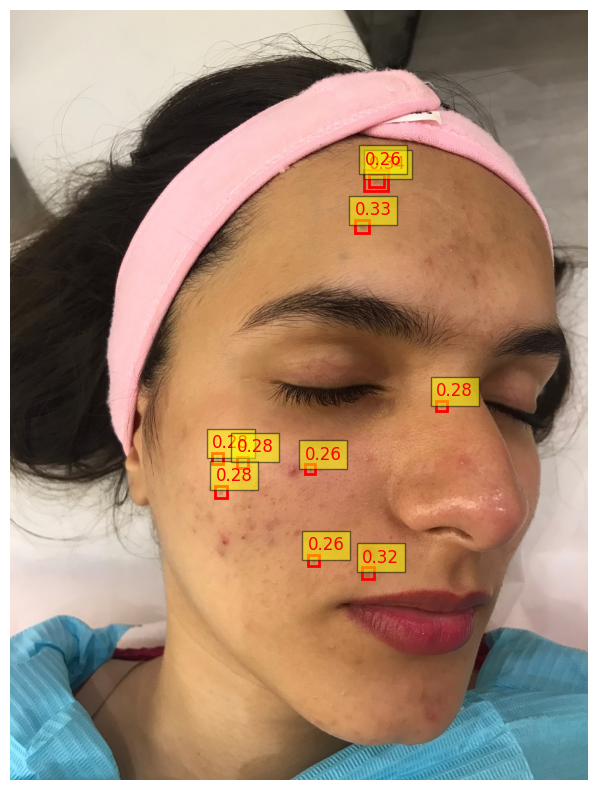

In [14]:
# Visualization function
def plot_predictions(image_path, predictions, score_threshold=0.5):
    """
    Plots predictions with bounding boxes and scores on the image.
    Args:
        image_path (str): Path to the image file.
        predictions (dict): Model predictions with 'boxes' and 'scores'.
        score_threshold (float): Minimum score to display a prediction.
    """
    image = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Ensure predictions are not empty
    if "boxes" in predictions and "scores" in predictions:
        for i, box in enumerate(predictions["boxes"]):
            score = predictions["scores"][i]
            if score >= score_threshold:
                x_min, y_min, x_max, y_max = box
                rect = patches.Rectangle(
                    (x_min, y_min), x_max - x_min, y_max - y_min,
                    linewidth=2, edgecolor="r", facecolor="none"
                )
                plt.gca().add_patch(rect)
                plt.text(
                    x_min, y_min - 10, f"{score:.2f}",
                    color="r", fontsize=12, bbox=dict(facecolor="yellow", alpha=0.5)
                )
    else:
        print("No predictions to display.")
    plt.axis("off")
    plt.show()

# Inference
model.eval()
test_image_path = "/kaggle/input/freckle-detection-dataset/dataset/dataset/train/c2.jpeg"
test_image = F.to_tensor(Image.open(test_image_path).convert("RGB")).unsqueeze(0).to(device)

with torch.no_grad():
    predictions = model(test_image)

# Format predictions for visualization
formatted_predictions = {
    "boxes": predictions[0]["boxes"].cpu().numpy(),
    "scores": predictions[0]["scores"].cpu().numpy(),
}

# Check predictions
print("Predictions:", formatted_predictions)

# Plot predictions
plot_predictions(test_image_path, formatted_predictions, score_threshold=0.25)


Predictions: {'boxes': array([[ 944.9806 , 3127.1846 , 1003.2753 , 3186.7932 ],
       [1940.501  , 1343.6377 , 1991.9868 , 1395.5599 ],
       [2049.1045 , 2146.2563 , 2106.395  , 2208.3914 ],
       [ 700.687  , 3250.918  ,  776.674  , 3316.7856 ],
       [ 568.73645, 2942.548  ,  614.72955, 2988.3296 ],
       [2269.6248 , 1975.2954 , 2322.8174 , 2028.5773 ],
       [2182.145  , 1720.843  , 2259.0554 , 1784.3043 ],
       [ 931.61743, 3472.6458 ,  981.20276, 3522.3774 ],
       [1179.045  , 3367.6328 , 1235.4865 , 3424.9524 ],
       [2177.8088 , 3601.429  , 2226.868  , 3652.0508 ],
       [1920.2709 , 1322.5735 , 2004.279  , 1410.996  ],
       [2027.2522 , 2129.4126 , 2116.318  , 2219.4    ],
       [2265.4382 , 3662.9497 , 2318.348  , 3714.6843 ],
       [1410.2623 , 1718.0615 , 1486.725  , 1786.5068 ],
       [1734.9052 , 1729.7261 , 1811.1694 , 1796.5099 ],
       [2225.6636 , 2100.9033 , 2285.5806 , 2158.6724 ],
       [2113.8384 , 2299.8335 , 2179.5508 , 2356.1733 ],
       [

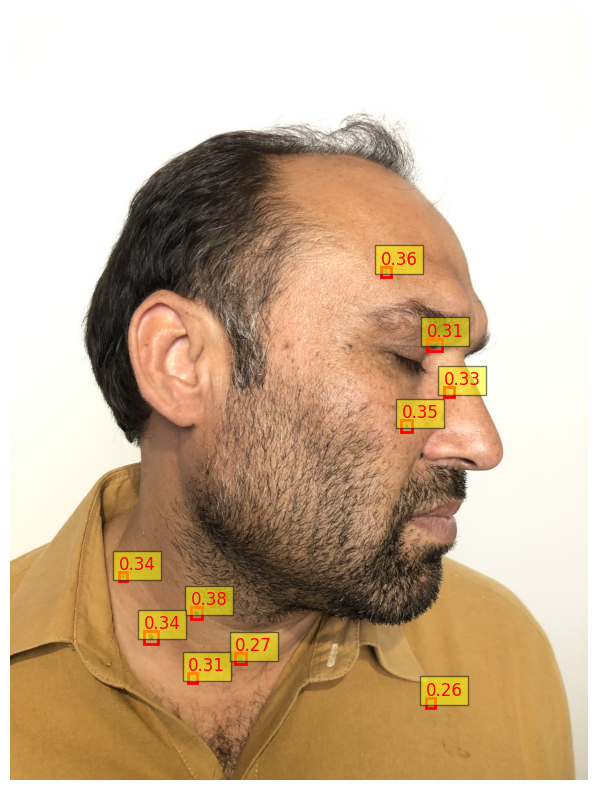

In [19]:
# Visualization function
def plot_predictions(image_path, predictions, score_threshold=0.5):
    """
    Plots predictions with bounding boxes and scores on the image.
    Args:
        image_path (str): Path to the image file.
        predictions (dict): Model predictions with 'boxes' and 'scores'.
        score_threshold (float): Minimum score to display a prediction.
    """
    image = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Ensure predictions are not empty
    if "boxes" in predictions and "scores" in predictions:
        for i, box in enumerate(predictions["boxes"]):
            score = predictions["scores"][i]
            if score >= score_threshold:
                x_min, y_min, x_max, y_max = box
                rect = patches.Rectangle(
                    (x_min, y_min), x_max - x_min, y_max - y_min,
                    linewidth=2, edgecolor="r", facecolor="none"
                )
                plt.gca().add_patch(rect)
                plt.text(
                    x_min, y_min - 10, f"{score:.2f}",
                    color="r", fontsize=12, bbox=dict(facecolor="yellow", alpha=0.5)
                )
    else:
        print("No predictions to display.")
    plt.axis("off")
    plt.show()

# Inference
model.eval()
test_image_path = "/kaggle/input/freckle-detection-dataset/dataset/dataset/val/IMG_7314.jpg"
test_image = F.to_tensor(Image.open(test_image_path).convert("RGB")).unsqueeze(0).to(device)

with torch.no_grad():
    predictions = model(test_image)

# Format predictions for visualization
formatted_predictions = {
    "boxes": predictions[0]["boxes"].cpu().numpy(),
    "scores": predictions[0]["scores"].cpu().numpy(),
}

# Check predictions
print("Predictions:", formatted_predictions)

# Plot predictions
plot_predictions(test_image_path, formatted_predictions, score_threshold=0.25)


Predictions: {'boxes': array([[ 969.657  , 2387.8416 , 1014.32135, 2438.1528 ],
       [ 945.6858 , 2367.8147 , 1037.1074 , 2462.6038 ],
       [ 880.55695, 1892.6774 ,  944.499  , 1955.0496 ],
       [1457.402  , 3470.2483 , 1518.8988 , 3526.3872 ],
       [ 962.3557 , 2389.6604 , 1028.4879 , 2454.0334 ],
       [1950.1521 , 2232.0845 , 2000.5481 , 2276.6174 ],
       [ 866.0022 , 1878.4165 ,  960.0243 , 1970.0416 ],
       [1446.816  , 3458.96   , 1539.533  , 3552.7896 ],
       [1193.9421 , 2357.394  , 1243.5973 , 2407.1553 ],
       [1932.923  , 2208.1733 , 2018.4602 , 2292.8052 ],
       [1783.5001 , 2401.435  , 1852.989  , 2464.1123 ],
       [2085.0745 , 1895.8215 , 2191.243  , 1995.0411 ]], dtype=float32), 'scores': array([0.3162491 , 0.17639288, 0.1620747 , 0.15499625, 0.12515609,
       0.12126132, 0.1031342 , 0.09548429, 0.07227886, 0.06431699,
       0.06052608, 0.05698074], dtype=float32)}


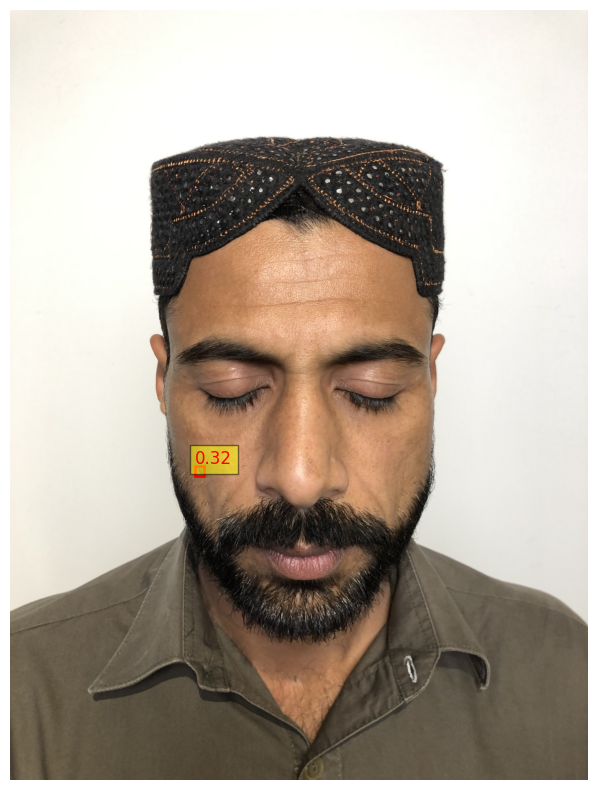

In [22]:
# Visualization function
def plot_predictions(image_path, predictions, score_threshold=0.5):
    """
    Plots predictions with bounding boxes and scores on the image.
    Args:
        image_path (str): Path to the image file.
        predictions (dict): Model predictions with 'boxes' and 'scores'.
        score_threshold (float): Minimum score to display a prediction.
    """
    image = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Ensure predictions are not empty
    if "boxes" in predictions and "scores" in predictions:
        for i, box in enumerate(predictions["boxes"]):
            score = predictions["scores"][i]
            if score >= score_threshold:
                x_min, y_min, x_max, y_max = box
                rect = patches.Rectangle(
                    (x_min, y_min), x_max - x_min, y_max - y_min,
                    linewidth=2, edgecolor="r", facecolor="none"
                )
                plt.gca().add_patch(rect)
                plt.text(
                    x_min, y_min - 10, f"{score:.2f}",
                    color="r", fontsize=12, bbox=dict(facecolor="yellow", alpha=0.5)
                )
    else:
        print("No predictions to display.")
    plt.axis("off")
    plt.show()

# Inference
model.eval()
test_image_path = "/kaggle/input/freckle-detection-dataset/dataset/dataset/val/IMG_7303.jpg"
test_image = F.to_tensor(Image.open(test_image_path).convert("RGB")).unsqueeze(0).to(device)

with torch.no_grad():
    predictions = model(test_image)

# Format predictions for visualization
formatted_predictions = {
    "boxes": predictions[0]["boxes"].cpu().numpy(),
    "scores": predictions[0]["scores"].cpu().numpy(),
}

# Check predictions
print("Predictions:", formatted_predictions)

# Plot predictions
plot_predictions(test_image_path, formatted_predictions, score_threshold=0.25)


Predictions: {'boxes': array([[1012.3736 , 2113.692  , 1063.8873 , 2162.682  ],
       [1104.3398 , 3242.788  , 1159.8993 , 3297.681  ],
       [1994.0671 , 1970.866  , 2049.9038 , 2039.0178 ],
       [2558.018  , 3666.0603 , 2618.2627 , 3720.5034 ],
       [1878.6257 , 1946.1241 , 1951.0217 , 2009.3009 ],
       [ 946.047  , 2033.8113 , 1003.7469 , 2090.0757 ],
       [1339.7001 , 3453.8667 , 1377.8341 , 3489.184  ],
       [1269.5363 , 2034.8021 , 1327.9014 , 2090.6082 ],
       [1507.5143 , 3349.8855 , 1569.2542 , 3420.755  ],
       [1210.8304 , 2235.143  , 1274.6567 , 2306.439  ],
       [ 849.81415, 1797.1614 ,  913.231  , 1855.477  ],
       [1673.811  , 1977.9651 , 1743.5415 , 2040.1326 ],
       [1895.7083 , 2034.6211 , 1962.3402 , 2095.2844 ],
       [ 923.5441 , 2012.035  , 1014.6642 , 2101.055  ],
       [1627.3132 , 1709.2955 , 1671.0273 , 1753.8071 ],
       [1186.8293 , 2218.2903 , 1290.7793 , 2319.9993 ],
       [1955.2744 , 1855.623  , 2020.4448 , 1927.5853 ],
       [

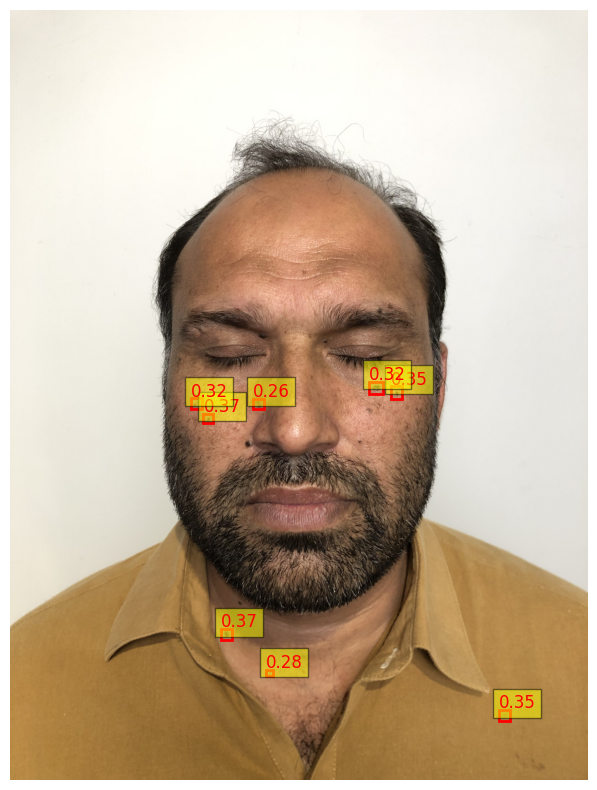

In [23]:
# Visualization function
def plot_predictions(image_path, predictions, score_threshold=0.5):
    """
    Plots predictions with bounding boxes and scores on the image.
    Args:
        image_path (str): Path to the image file.
        predictions (dict): Model predictions with 'boxes' and 'scores'.
        score_threshold (float): Minimum score to display a prediction.
    """
    image = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Ensure predictions are not empty
    if "boxes" in predictions and "scores" in predictions:
        for i, box in enumerate(predictions["boxes"]):
            score = predictions["scores"][i]
            if score >= score_threshold:
                x_min, y_min, x_max, y_max = box
                rect = patches.Rectangle(
                    (x_min, y_min), x_max - x_min, y_max - y_min,
                    linewidth=2, edgecolor="r", facecolor="none"
                )
                plt.gca().add_patch(rect)
                plt.text(
                    x_min, y_min - 10, f"{score:.2f}",
                    color="r", fontsize=12, bbox=dict(facecolor="yellow", alpha=0.5)
                )
    else:
        print("No predictions to display.")
    plt.axis("off")
    plt.show()

# Inference
model.eval()
test_image_path = "/kaggle/input/freckle-detection-dataset/dataset/dataset/val/IMG_7312.jpg"
test_image = F.to_tensor(Image.open(test_image_path).convert("RGB")).unsqueeze(0).to(device)

with torch.no_grad():
    predictions = model(test_image)

# Format predictions for visualization
formatted_predictions = {
    "boxes": predictions[0]["boxes"].cpu().numpy(),
    "scores": predictions[0]["scores"].cpu().numpy(),
}

# Check predictions
print("Predictions:", formatted_predictions)

# Plot predictions
plot_predictions(test_image_path, formatted_predictions, score_threshold=0.25)


Predictions: {'boxes': array([[284.1825 , 519.9144 , 298.97525, 535.455  ],
       [279.28418, 515.33923, 301.15088, 538.51044],
       [339.84622, 522.24347, 353.96387, 537.4078 ],
       [329.1282 , 533.7979 , 343.86923, 547.6634 ],
       [354.77066, 431.89996, 369.8615 , 448.51846],
       [332.92004, 517.1168 , 357.71796, 542.2594 ],
       [364.44818, 538.98663, 378.384  , 552.6459 ],
       [350.67667, 428.58075, 374.0901 , 452.71976],
       [360.00934, 534.715  , 381.2484 , 555.6652 ],
       [325.59973, 529.8445 , 347.79767, 551.72235],
       [329.68396, 722.75415, 349.59174, 742.7327 ]], dtype=float32), 'scores': array([0.3778418 , 0.25077873, 0.19908415, 0.15703735, 0.15679257,
       0.12859726, 0.11971149, 0.09886923, 0.0868853 , 0.0833247 ,
       0.05322199], dtype=float32)}


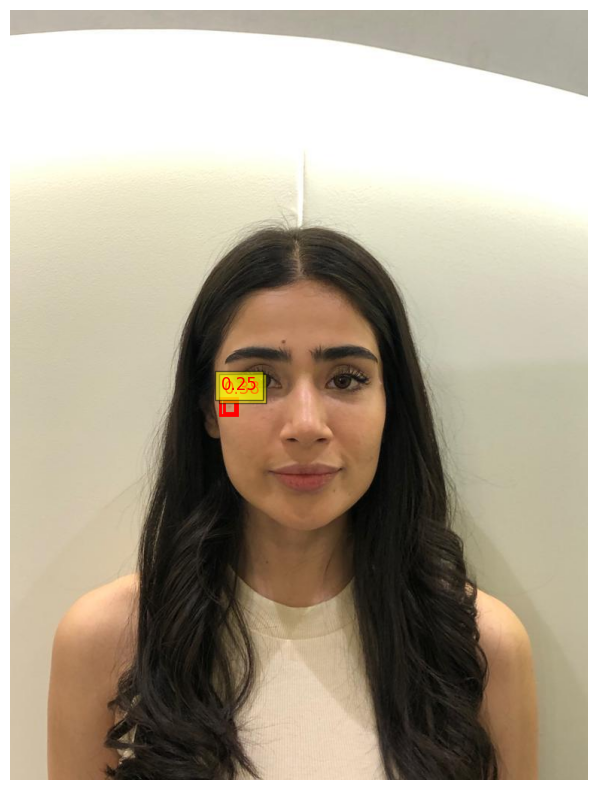

In [25]:
# Visualization function
def plot_predictions(image_path, predictions, score_threshold=0.5):
    """
    Plots predictions with bounding boxes and scores on the image.
    Args:
        image_path (str): Path to the image file.
        predictions (dict): Model predictions with 'boxes' and 'scores'.
        score_threshold (float): Minimum score to display a prediction.
    """
    image = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Ensure predictions are not empty
    if "boxes" in predictions and "scores" in predictions:
        for i, box in enumerate(predictions["boxes"]):
            score = predictions["scores"][i]
            if score >= score_threshold:
                x_min, y_min, x_max, y_max = box
                rect = patches.Rectangle(
                    (x_min, y_min), x_max - x_min, y_max - y_min,
                    linewidth=2, edgecolor="r", facecolor="none"
                )
                plt.gca().add_patch(rect)
                plt.text(
                    x_min, y_min - 10, f"{score:.2f}",
                    color="r", fontsize=12, bbox=dict(facecolor="yellow", alpha=0.5)
                )
    else:
        print("No predictions to display.")
    plt.axis("off")
    plt.show()

# Inference
model.eval()
test_image_path = "/kaggle/input/freckle-detection-dataset/dataset/dataset/train/aaa3.jpg"
test_image = F.to_tensor(Image.open(test_image_path).convert("RGB")).unsqueeze(0).to(device)

with torch.no_grad():
    predictions = model(test_image)

# Format predictions for visualization
formatted_predictions = {
    "boxes": predictions[0]["boxes"].cpu().numpy(),
    "scores": predictions[0]["scores"].cpu().numpy(),
}

# Check predictions
print("Predictions:", formatted_predictions)

# Plot predictions
plot_predictions(test_image_path, formatted_predictions, score_threshold=0.25)
